# Time Series on Seattle Bike Data
---
I followed a time series analysis tutorial on [Seattle bike data](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k) based on this blog post: [Is Seattle Really Seeing an Uptick In Cycling?](http://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/)

# The Data
- Bike data from [data.seattle.gov](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k)
- Weather data from [National Climatic Data Center](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (2012/10/1 - 2014/5/14)

# Examining the Fremont Bridge Data

In [203]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set('talk')
sns.set_style("whitegrid")
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 7 # change default figure size

## Load the bike data

In [204]:
df = pd.read_csv("data/Seattle_bike.csv")
df.head()

,Date,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
0,10/03/2012 12:00:00 AM,4,9
1,10/03/2012 01:00:00 AM,4,6
2,10/03/2012 02:00:00 AM,1,1
3,10/03/2012 03:00:00 AM,2,3
4,10/03/2012 04:00:00 AM,6,1


In [205]:
# Load the data file, and create a column with total north/south traffic

hourly = pd.read_csv("data/Seattle_bike.csv", index_col='Date', parse_dates=True)
# index_col: Column to use as the row labels of the DataFrame. 
# parse_dates: If True -> try parsing the index. 

# West Sidewalk -> northbound, East Sidewalk -> southbound
hourly.columns = ['northbound', 'southbound']
hourly['total'] = hourly['northbound'] + hourly['southbound']
print hourly.head()

                     northbound  southbound  total
Date                                              
2012-10-03 00:00:00           4           9     13
2012-10-03 01:00:00           4           6     10
2012-10-03 02:00:00           1           1      2
2012-10-03 03:00:00           2           3      5
2012-10-03 04:00:00           6           1      7


In [206]:
# Resample the data into daily and weekly totals
"""
    pandas.DataFrame.resample
    - Convenience method for frequency conversion and resampling of regular time-series data.
"""
daily = hourly.resample('d', 'sum')
weekly = daily.resample('w', 'sum')

print daily.head()
print weekly.head()

            northbound  southbound  total
Date                                     
2012-10-03        1760        1761   3521
2012-10-04        1708        1767   3475
2012-10-05        1558        1590   3148
2012-10-06        1080         926   2006
2012-10-07        1191         951   2142
            northbound  southbound  total
Date                                     
2012-10-07        7297        6995  14292
2012-10-14        8679        8116  16795
2012-10-21        7946        7563  15509
2012-10-28        6901        6536  13437
2012-11-04        6408        5786  12194


## Raw data

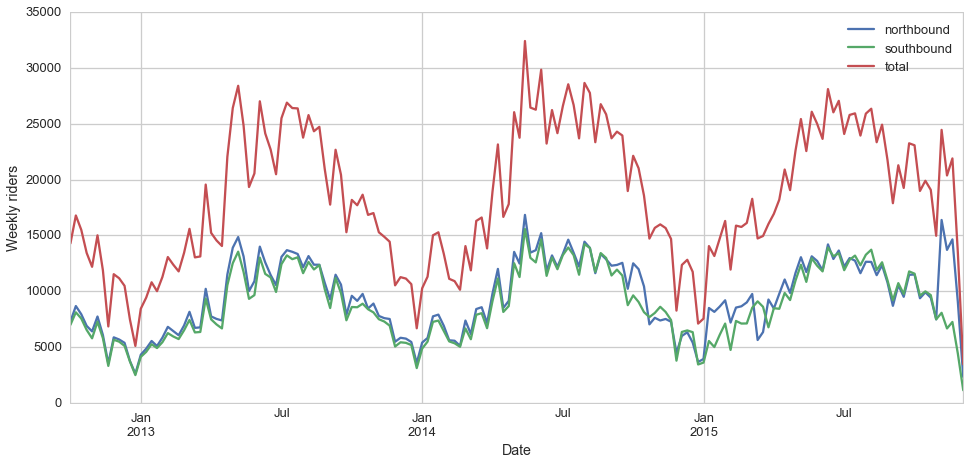

In [207]:
weekly[['northbound', 'southbound', 'total']].plot()
plt.ylabel('Weekly riders');

At first glance, **April and May 2014** include some spikes in the data: over 32,000 riders per week crossed the bridge one week in May! This trend might be a bit clearer if we use a **moving window average**: basically, for each day we'll take the average of the 30-day period around it:

## Rolling mean

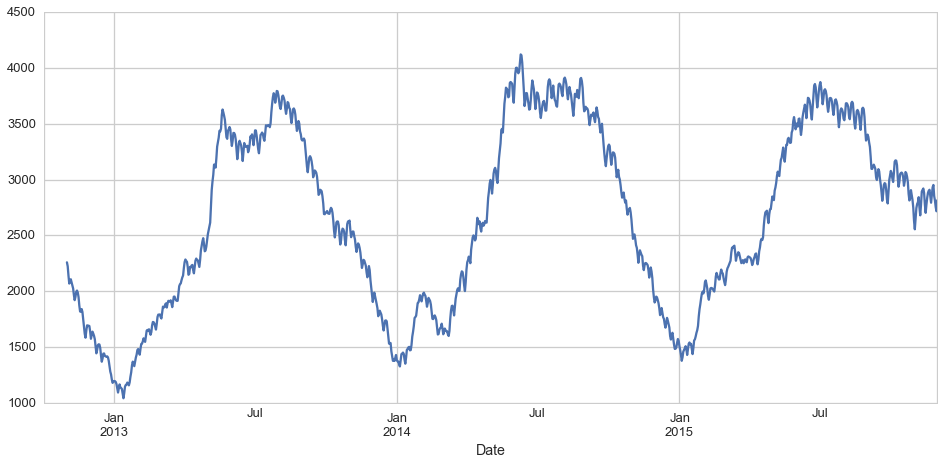

In [208]:
"""pandas provide moving (rolling) statics"""

# the methods are in the pandas namespace, but otherwise they can be found in pandas.stats.moments
pd.stats.moments.rolling_mean(daily['total'], 30).plot(); # pd.rolling_mean also works

This is the increased ridership that folks have been talking about. There is some seasonal variation, but the trend seems clear: **2014 has seen a lot of cyclists crossing the bridge.**

## Seasonal variation
But it is clear that there is still some **seasonal variation**. What we're going to try to do below is to model this variation based on our intuition about what factors might come into play in people's decision about whether to ride.

For simplicity, we are using a **linear model** here. It would be possible to go deeper and use a more sophisticated model (I'd eventually like to try Random Forests), but a linear model should give us a good approximation of what's happening.

# 1. Accounting for Hours of Daylight
## 1.1 Hypothesis: The daylight hours affects traffic
We'll compute the number of hours of daylight and use this to de-trend the data.
### Computing the hours of daylight for a given date

In [209]:
# Define a function which returns the hours of daylight given the day of the year, from 0 to 365

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

# add this to our weekly data
weekly['daylight'] = map(hours_of_daylight, weekly.index)
daily['daylight'] = map(hours_of_daylight, daily.index)

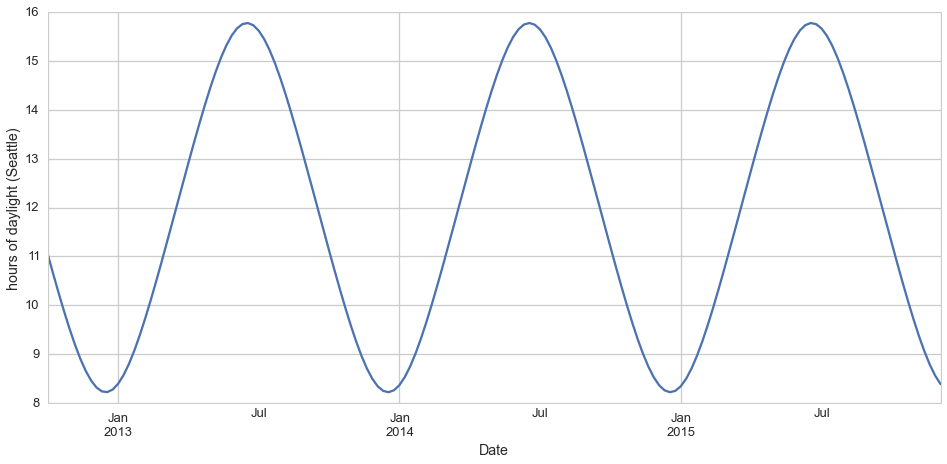

In [210]:
# Plot the daylight curve

weekly['daylight'].plot()
plt.ylabel('hours of daylight (Seattle)');

### The daylight hours vs. the weekly traffic

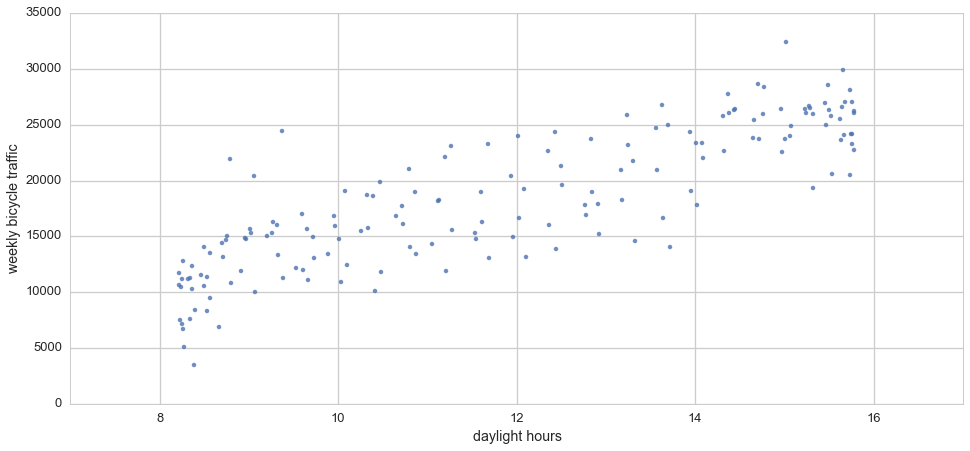

In [211]:
# seaborn
sns.regplot(weekly['daylight'], weekly['total'], fit_reg=False)
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

## 1.2 Building a linear model

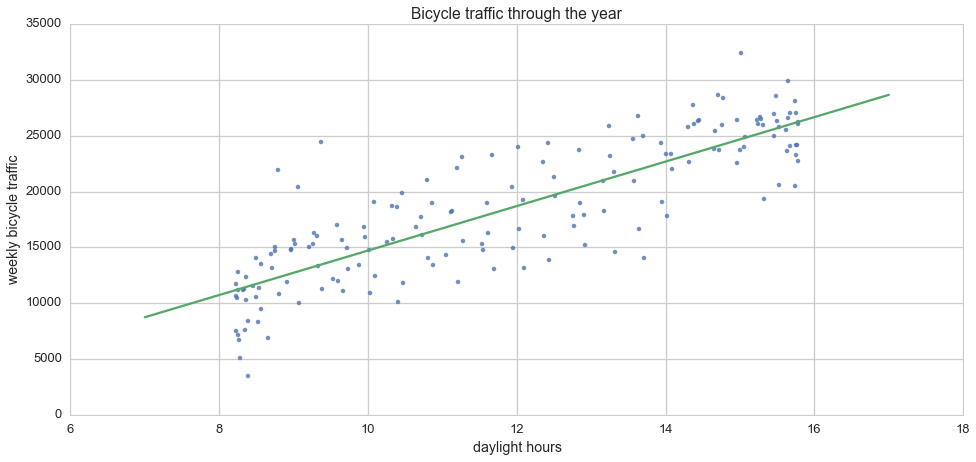

In [212]:
from sklearn.linear_model import LinearRegression

# X = weekly[['daylight']].to_dense() # this is to create X as df (or dense matrix)
# For a single column, pandas single bracket returns a Series, double bracket returns a DataFrame

X = weekly[['daylight']]
y = weekly['total']
reg = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = reg.predict(X)
weekly['daylight_corrected_total'] = weekly['total'] - weekly['daylight_trend'] + weekly['daylight_trend'].mean()

xfit = np.linspace(7, 17)
yfit = reg.predict(xfit[:, None]) # predcit requires sparse matrix or dataframe (ex. reg.predict(pd.DataFrame(xfit))

sns.regplot(weekly['daylight'], weekly['total'], fit_reg=False)
plt.plot(xfit, yfit)
plt.title("Bicycle traffic through the year")
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

In [213]:
print reg.coef_[0]

1992.86802992


Each extra hour of daylight leads to about 2000 more riders per week across the bridge. 
- Of course, in Seattle the length of the day also correlates highly with temperature and precipitation; we'll try to untangle those effects later.

## 1.3 Correcting the seasonal variation: de-trending the data
### Removing the daylight-hours factor
Subtract the linear "trend" off and replace it by the mean

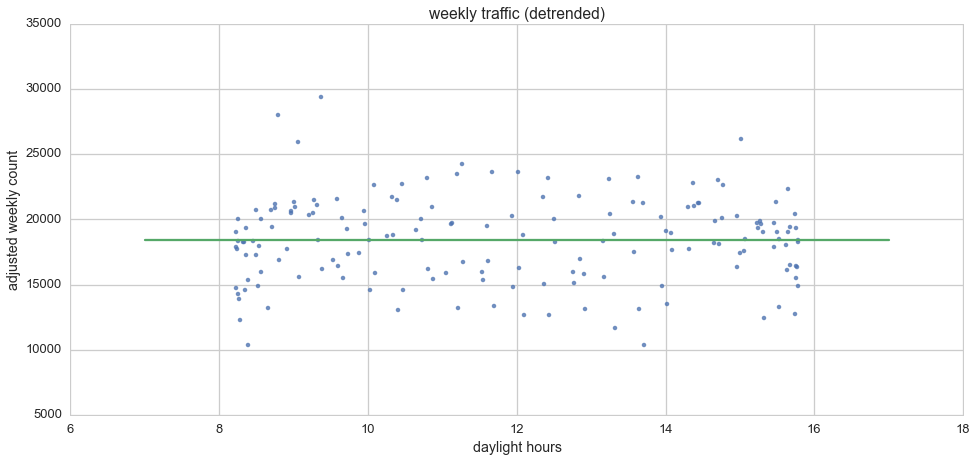

In [214]:
# trend = reg.predict(weekly[['daylight']].as_matrix())
trend = reg.predict(weekly[['daylight']])

sns.regplot(weekly['daylight'], weekly['total'] - trend + np.mean(trend), fit_reg=False)
plt.plot(xfit, np.mean(trend) + 0 * yfit)
plt.title("weekly traffic (detrended)")
plt.xlabel('daylight hours')
plt.ylabel('adjusted weekly count');

The "adjusted weekly count" plotted here can be thought of as the number of cyclists we'd expect to see if the hours of daylight were not a factor.

### The traffic vs. the day of the year, along with the trend

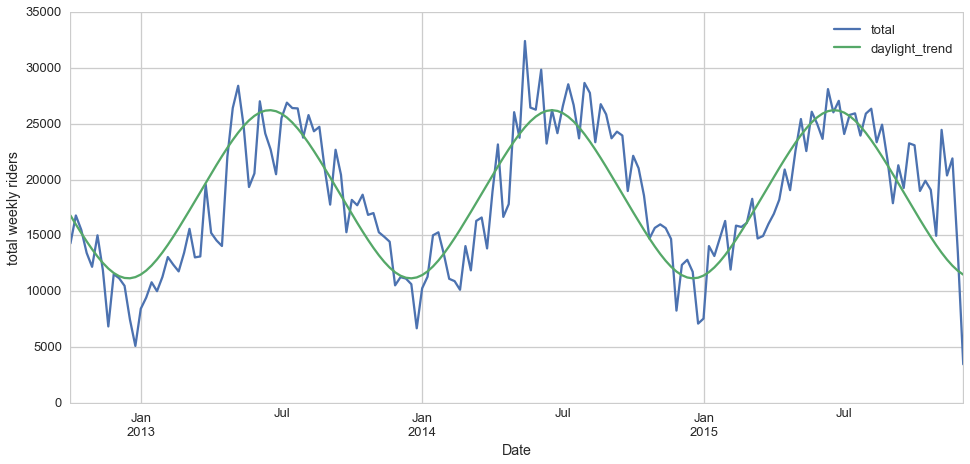

In [215]:
weekly[['total', 'daylight_trend']].plot() # pandas df support a simple plot method
plt.ylabel("total weekly riders");

### The de-trended plot

root-mean-square about trend: 3280 riders


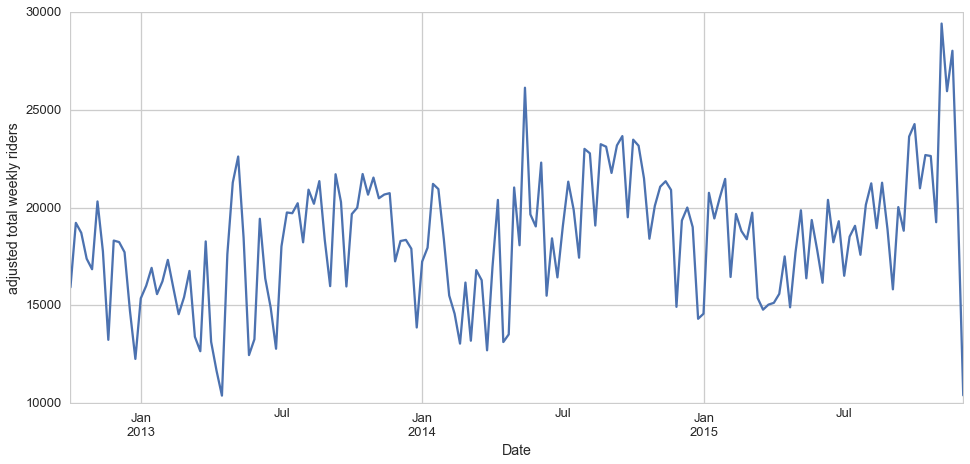

In [216]:
weekly['daylight_corrected_total'].plot()
rms = np.std(weekly['daylight_corrected_total'])
plt.ylabel("adjusted total weekly riders")
print "root-mean-square about trend: {0:.0f} riders".format(rms)

With the data de-trended, we get a better idea of how bicycling in Seattle has changed over time, **corrected for the seasonal variation.**

# 2. Accounting for Day of the Week
## 2.1 Hypothesis: The day of the week affects traffic

In [217]:
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'] # Monday=0, Sunday=6
daily['dayofweek'] = daily['total'].index.dayofweek

In [218]:
print daily.groupby('dayofweek').mean()['total']

dayofweek
0    3094.654545
1    3284.719512
2    3250.793939
3    3105.133333
4    2790.727273
5    1532.490909
6    1492.127273
Name: total, dtype: float64


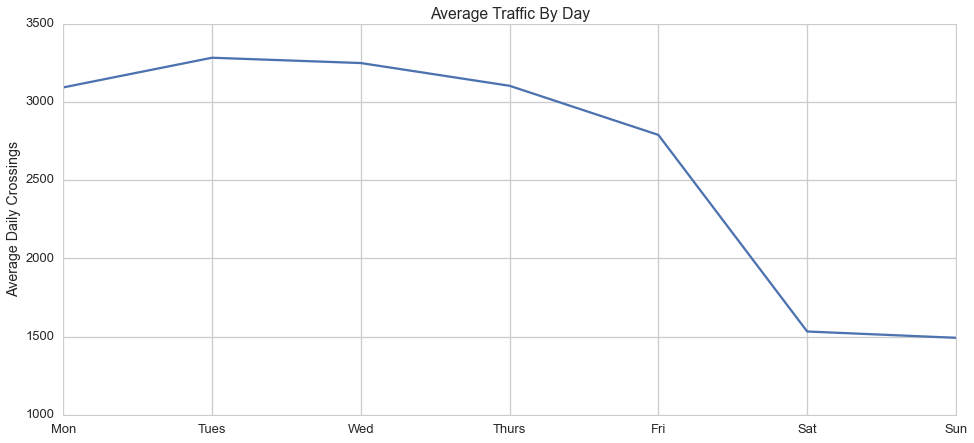

In [219]:
grouped = daily.groupby('dayofweek').mean()['total'] # this also works: daily.groupby('dayofweek')['total'].mean()
grouped.index = days

grouped.plot()
plt.title("Average Traffic By Day")
plt.ylabel("Average Daily Crossings");

There is roughly 2.5 times the amount of traffic on weekdays as there is on weekends. In Seattle, at least, they are a real means of commuting for thousands of people per day, and the data show this clearly.

## 2.2 Correcting the seasonal variation: de-trending
We'll add a variable for each day of the week, and use each of these within the trend (this is an example of **"one-hot" encoding**).

In [220]:
# Add one-hot indicators of weekday
for i in range(7):
    # Loop over each day, and create a day-of-week column, add one-hot indicator
    daily[days[i]] = (daily.index.dayofweek == i).astype(float) # astype(float) converts false to 0 (float)

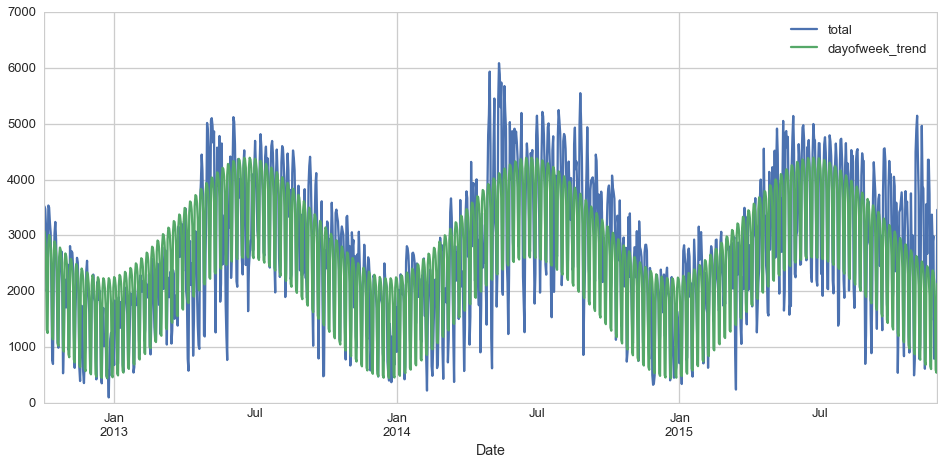

In [221]:
# Build a linear regression model including both day-of-week and daylight hours
X = daily[days + ['daylight']] # list + list
y = daily['total']
clf = LinearRegression().fit(X, y)

# plot the prediction
daily['dayofweek_trend'] = clf.predict(X)
daily[['total', 'dayofweek_trend']].plot();    

rms = 692


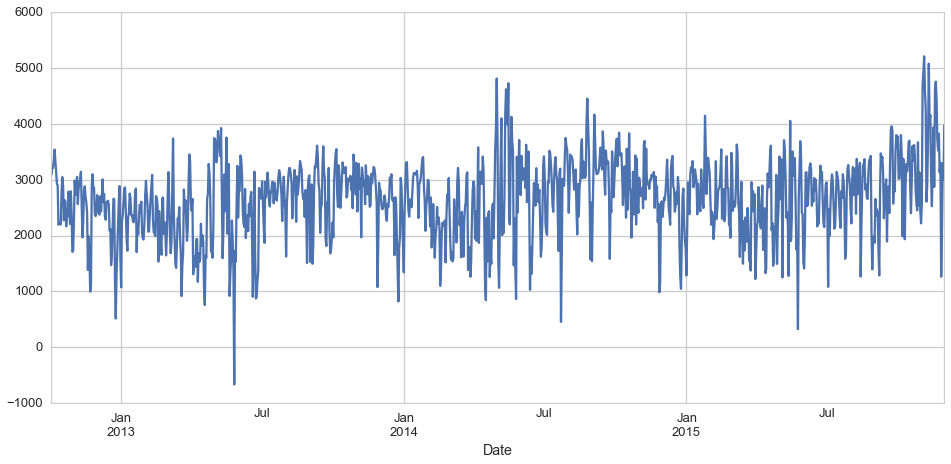

In [222]:
# de-trend on days of the week and daylight together
daily['dayofweek_corrected'] = (daily['total'] - daily['dayofweek_trend'] + daily['dayofweek_trend'].mean())
print("rms = {0:.0f}".format(np.std(daily['dayofweek_corrected'])))
daily['dayofweek_corrected'].plot();

# 3. Accounting for Temperature and Precipitation

In [226]:
# Read the weather file
df = pd.read_csv('data/Seattle_weather.csv')
print df.head() # this is how it looks like

             STATION                                STATION_NAME      DATE  \
0  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US  20121001   
1  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US  20121002   
2  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US  20121003   
3  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US  20121004   
4  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US  20121005   

   PRCP  SNWD  SNOW  TMAX  TMIN  AWND  WDF2  ...   WT01  WT05  WT02  WT22  \
0     0     0     0   233    89    30    40  ...  -9999 -9999 -9999 -9999   
1     0     0     0   178   100    41    10  ...  -9999 -9999 -9999 -9999   
2     0     0     0   189    78    73    10  ...  -9999 -9999 -9999 -9999   
3     0     0     0   189    83    65    20  ...  -9999 -9999 -9999 -9999   
4     0     0     0   217    89    57   360  ...  -9999 -9999 -9999 -9999   

   WT04  WT13  WT16  WT08  WT18  WT03  
0 -9999 -9999 -9999 -9999 -9

In [233]:
# date, precipitation, max temp, min temp
print df.columns[[2,3,6,7]]

Index([u'DATE', u'PRCP', u'TMAX', u'TMIN'], dtype='object')


In [235]:
# Read the weather file
weather = pd.read_csv('data/Seattle_weather.csv', index_col='DATE', parse_dates=True, usecols=[2, 3, 6, 7])
print weather.head()

            PRCP  TMAX  TMIN
DATE                        
2012-10-01     0   233    89
2012-10-02     0   178   100
2012-10-03     0   189    78
2012-10-04     0   189    83
2012-10-05     0   217    89


In [236]:
# Convert units
# temperatures are in 1/10 deg C; convert to F
weather['TMIN'] = 0.18 * weather['TMIN'] + 32
weather['TMAX'] = 0.18 * weather['TMAX'] + 32

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254

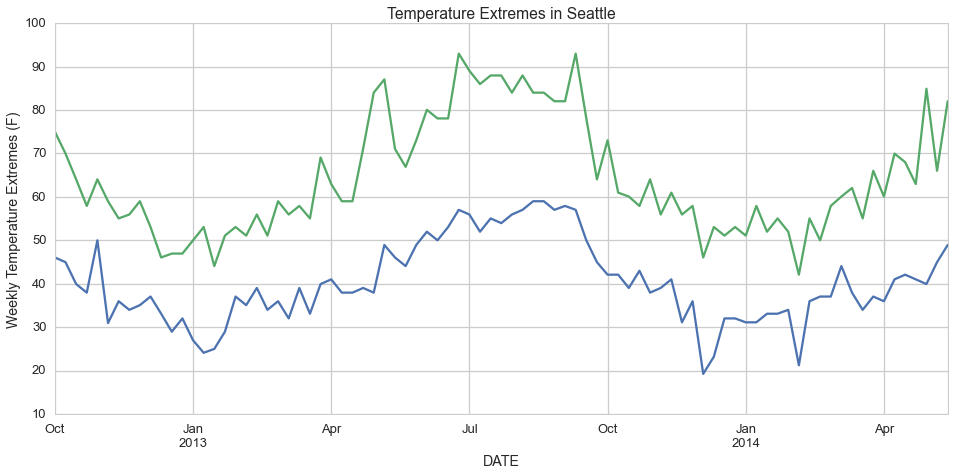

In [242]:
weather['TMIN'].resample('w', 'min').plot()
weather['TMAX'].resample('w', 'max').plot()
plt.ylabel('Weekly Temperature Extremes (F)');
plt.title("Temperature Extremes in Seattle");

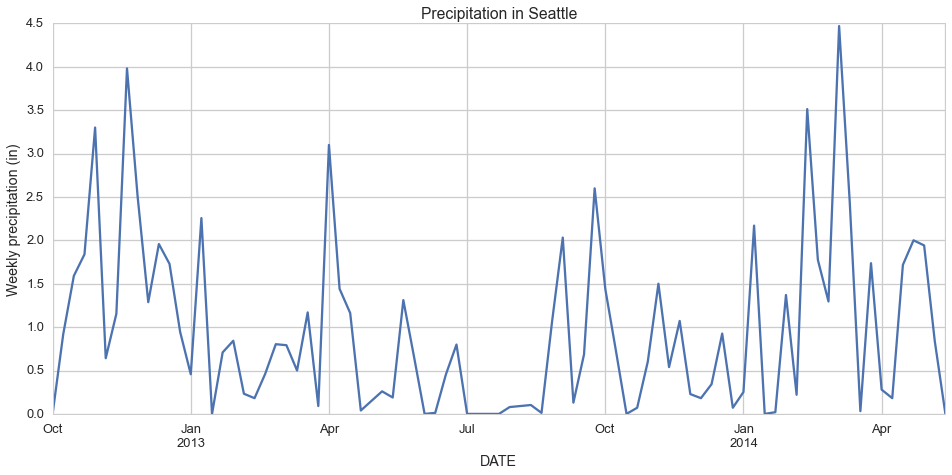

In [243]:
weather['PRCP'].resample('w', 'sum').plot();
plt.ylabel('Weekly precipitation (in)')
plt.title("Precipitation in Seattle");

In [244]:
# join the weather data to our daily data
daily = daily.join(weather)

In [194]:
print daily.tail()

            northbound  southbound  total  daylight  dayofweek  Mon  Tues  \
Date                                                                        
2015-11-26         532         259    791  8.651343          3    0     0   
2015-11-27         882         461   1343  8.619793          4    0     0   
2015-11-28         798         439   1237  8.589290          5    0     0   
2015-11-29         605         293    898  8.559855          6    0     0   
2015-11-30        2329        1132   3461  8.531511          0    1     0   

            Wed  Thurs  Fri  Sat  Sun  dayofweek_trend  dayofweek_corrected  \
Date                                                                          
2015-11-26    0      1    0    0    0      2178.637715          1261.904746   
2015-11-27    0      0    1    0    0      1855.913467          2136.628994   
2015-11-28    0      0    0    1    0       589.650738          3296.891723   
2015-11-29    0      0    0    0    1       541.558536          3

In [199]:
daily2 = daily.dropna(subset=['PRCP'])

In [200]:
print daily2.tail()

            northbound  southbound  total   daylight  dayofweek  Mon  Tues  \
Date                                                                         
2014-05-10         967         758   1725  14.668383          5    0     0   
2014-05-11        1300        1076   2376  14.714328          6    0     0   
2014-05-12        2727        2705   5432  14.759615          0    1     0   
2014-05-13        3080        3008   6088  14.804222          1    0     1   
2014-05-14        3035        2852   5887  14.848126          2    0     0   

            Wed  Thurs  Fri  Sat  Sun  dayofweek_trend  dayofweek_corrected  \
Date                                                                          
2014-05-10    0      0    0    1    0      2329.157406          2045.385055   
2014-05-11    0      0    0    0    1      2302.634845          2722.907616   
2014-05-12    0      0    0    0    0      3918.806509          4162.735952   
2014-05-13    0      0    0    0    0      4116.427889    

/Users/Hongsup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


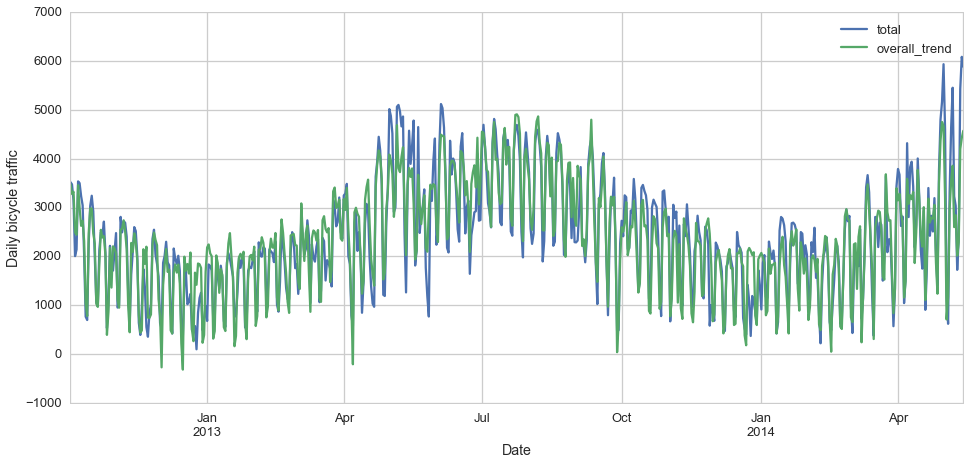

In [201]:
columns = days + ['daylight', 'TMIN', 'TMAX', 'PRCP']

X = daily2[columns]
y = daily2['total']
clf = LinearRegression().fit(X, y)
daily2['overall_trend'] = clf.predict(X)

# Plot the overall trend
daily2[['total', 'overall_trend']].plot()
plt.ylabel('Daily bicycle traffic');

rms = 455


/Users/Hongsup/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


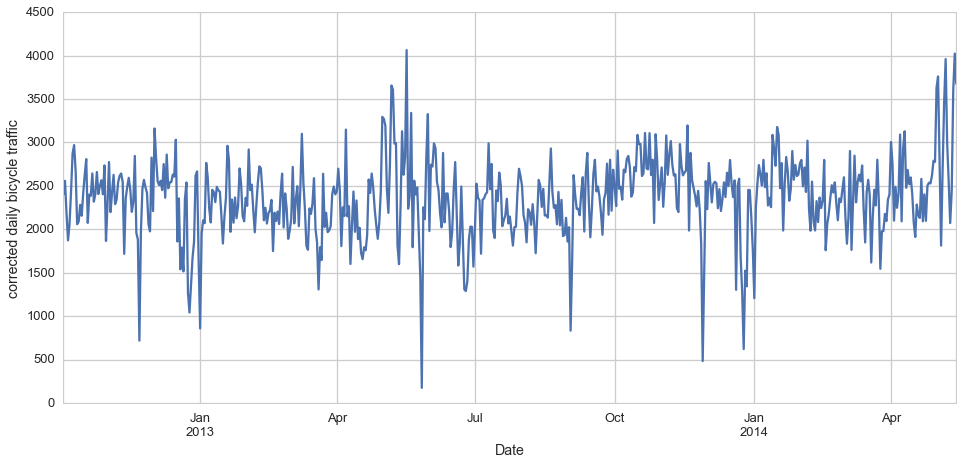

In [202]:
daily2['overall_corrected'] = daily2['total'] - daily2['overall_trend'] + daily2['overall_trend'].mean()
print("rms = {0:.0f}".format(np.std(daily2['overall_corrected'])))
daily2['overall_corrected'].plot()
plt.ylabel('corrected daily bicycle traffic');
